In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize 
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from matplotlib import rcParams
rcParams['text.usetex'] = False

# Set the font globally to DejaVu Sans
rcParams['font.family'] = 'DejaVu Sans'

In [2]:
def michaelis_menten(s, vmax, km):
    return (vmax * s) / (km + s)


In [3]:

# Load the CSV file into a DataFrame
data = pd.read_csv('ArsA_WT.csv')
data_N = pd.read_csv('ArsA_D46N.csv')
data_C = pd.read_csv('ArsA_D364N.csv')
data_DM = pd.read_csv('ArsA_DM1.csv')

S = data['S'].values

# rates in nmol/min/mg
rate = data.drop(columns=['S']).values * 1008              
rate_DM = data_DM.drop(columns=['S']).values * 587
rate_N = data_N.drop(columns=['S']).values * 1008
rate_C = data_C.drop(columns=['S']).values * 1008



V = rate.mean(axis=1)
V_N = rate_N.mean(axis=1)
V_DM = rate_DM.mean(axis=1)
V_C = rate_C.mean(axis=1)

y_sd = rate.std(axis=1)
y_sd_N = rate_N.std(axis=1)
y_sd_DM = rate_DM.std(axis=1)
y_sd_C = rate_C.std(axis=1)

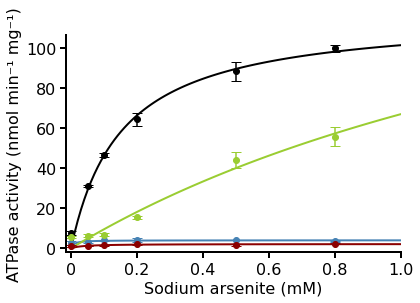

In [5]:
# Define the loss functions for each dataset
def loss(theta):
    v_max, k_m = theta
    v_pred = michaelis_menten(S, v_max, k_m)
    return np.sum((V - v_pred)**2)

def loss_variant(S, V, theta):
    v_max, k_m = theta
    v_pred = michaelis_menten(S, v_max, k_m)
    return np.sum((V - v_pred)**2)

# Optimize parameters for each dataset
res = minimize(loss, [0.2, 1])
res_N = minimize(lambda theta: loss_variant(S, V_N, theta), [0.2, 1])
res_C = minimize(lambda theta: loss_variant(S, V_C, theta), [0.2, 1])
res_DM = minimize(lambda theta: loss_variant(S, V_DM, theta), [0.2, 1])

# Generate scatter plots with error bars
def plot_data_and_fit(S, V, yerr, fit_params, color, label, linestyle='-'):
    plt.errorbar(S, V, yerr=yerr, fmt='o', capsize=5, capthick=1, color=color, label=f'{label} SEM')
    s_plot = np.linspace(0, 1, 100)
    plt.plot(s_plot, michaelis_menten(s_plot, fit_params[0], fit_params[1]), color=color, linestyle=linestyle, linewidth=2)



# Plot data and fits using shifted x-values
plot_data_and_fit(S, V, y_sd, res.x, 'black', 'WT')
plot_data_and_fit(S, V_N, y_sd_N, res_N.x, 'steelblue', 'N')
plot_data_and_fit(S, V_C, y_sd_C, res_C.x, 'yellowgreen', 'C')
plot_data_and_fit(S, V_DM, y_sd_DM, res_DM.x, 'darkred', 'DM')

    
# Adjust axis limits to add padding
plt.xlim(left=-0.015, right=1)  # Ensure a buffer on the left side
plt.ylim(bottom=-2)

# Add margins if needed
plt.margins(x=0.1)

# Remove the top and right spines (edges)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Set font size for axis labels (tick values)
plt.xticks(fontsize=16)  # Font size for x-axis ticks
plt.yticks(fontsize=16)  # Font size for y-axis ticks

# Increase stroke width of the spines
plt.gca().spines['left'].set_linewidth(2)  # Left spine width
plt.gca().spines['bottom'].set_linewidth(2)  # Bottom spine width

# Change tick mark line width
plt.tick_params(axis='both', width=2, length=6)  # Change the tick mark width to 2

# Create a custom formatter for the X-axis labels
def custom_format(x, pos):
    if x == 0:
        return '0'  # For the 0 label, just display 0
    else:
        return f'{x:.1f}'  # For other ticks, display 1 decimal place

# Set the formatter for the x-axis to apply custom formatting
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(custom_format))

# Add labels and save the plot
plt.xlabel('Sodium arsenite (mM)', fontsize =16)
plt.ylabel('ATPase activity (nmol min\u207B\u00B9 mg\u207B\u00B9)', fontsize =16)
plt.savefig('LfArsA_WT_SwitchI_new.eps', bbox_inches='tight' )
plt.show()
